In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from preprocess_daight import Cleaner
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

link val dataset = https://www.kaggle.com/datasets/zeyadusf/daigt-all-data-for-competition

## Import data

In [2]:
data = pd.read_csv("/content/Training_Essay_Data.csv")
data.head()

,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1


In [3]:
df = data.copy()
df.shape

(29145, 2)

In [4]:
df.isna().any()

,0
text,False
generated,False


## Label Distribution

Chart below is count of distribution for each labels

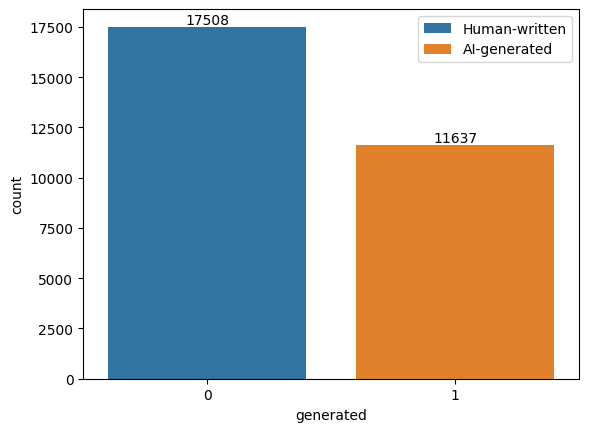

In [5]:
ax = sns.countplot(data=df, x='generated', hue='generated')
ax.legend(loc="upper right", labels=["Human-written", "AI-generated"])
for container in ax.containers:
  ax.bar_label(container)
plt.show()

In [6]:
# Finding ratio between 2 labels
percentage = lambda val: (val / df.shape[0]) * 100
for bar in ax.containers:
  percent = percentage(bar.datavalues[0])
  # Result of ratio according to full data
  print(round(percent))

60
40


📌 **Findings:**

This dataset is not balance with 17.508 human written text and 11.637 AI generated text.

We usually need to balancing this dataset with resample techniques, so the model is not bias to majority label. But, in this dataset the different between label is not that big (ratio 60:40). So, we need to see confusion matrix first to decide we need resample or no.

In [7]:
from bs4 import BeautifulSoup
import re

def clean_html(text: str):
  text = BeautifulSoup(text, "html.parser").get_text()
  return text

def remove_esc_char(text: str):
  text = re.sub(r"[\n\r\t\b]", ' ', text)
  text = re.sub(r"[\\']", "'", text)
  return text

def remove_link(text: str):
  pat_link = r'(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*'
  text = re.sub(pat_link, '', text)
  return text

def normalize_punct(text: str):
  text = re.sub(r"[‘’]", "'", text)
  text = re.sub(r'[“”]', '"', text)
  text = re.sub(r"(…)", '...', text)
  text = re.sub(r"[–—−]", '-', text)
  text = re.sub(r'[\u00A0\u2009\u202F]', ' ', text)
  return text

def cleaning(text: str):
  text = clean_html(text)
  text = remove_link(text)
  text = remove_esc_char(text)
  text = normalize_punct(text)
  return text



text = df.loc[2840].text
text_pr = remove_esc_char(text)
text_rl = remove_link(text_pr)
text_cleaned = cleaning(text)
print(text_cleaned)

Operating a motor vehicle while on your cell phone  Being on your device and driving could be an overly dangerous choice in life. Many people around the world are injured by this situation every day. It could lead to accidents and altercations. In addition it would even cost you your licences. The most detrimental outcome is death. There are far more outcomes to operating a motor vehicle while being on a cell phone. Drivers should not be able to use cell phones in any capacity while operating a motor vehicle.  One leading cause to motor vehicle accidents is being on your cell phone. It could lead to accidents and altercations. Yourself and the passengers are more at risk to bodily injuries and harm. These bodily injuries and harm can range anywhere from mild to critical condition. In an motor vehicle accident there is more than one involved. There is another person or group of people that could have the exact same conditions than the driver on the cell phone. In an example of an alterc

## Data Cleaning

In [9]:
cleaner = Cleaner(return_token=False, train_data=True)
df["text"] = cleaner.transform(df)

## Feature Engineering


### Word Length

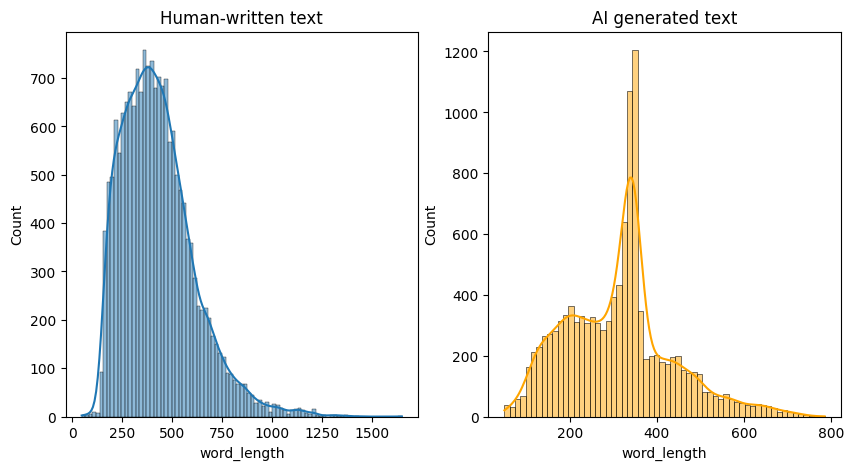

In [23]:
# Create word_length feature
df["word_length"] = df["text"].apply(utils.word_length)

# Filtering dataframe
human_written = df[df["generated"] == 0]
ai_generated = df[df["generated"] == 1]

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(data=human_written, x='word_length', kde=True, ax=ax[0])
ax[0].set_title("Human-written text")
sns.histplot(data=ai_generated, x='word_length', kde=True, ax=ax[1], color='orange')
ax[1].set_title("AI generated text")
plt.show()

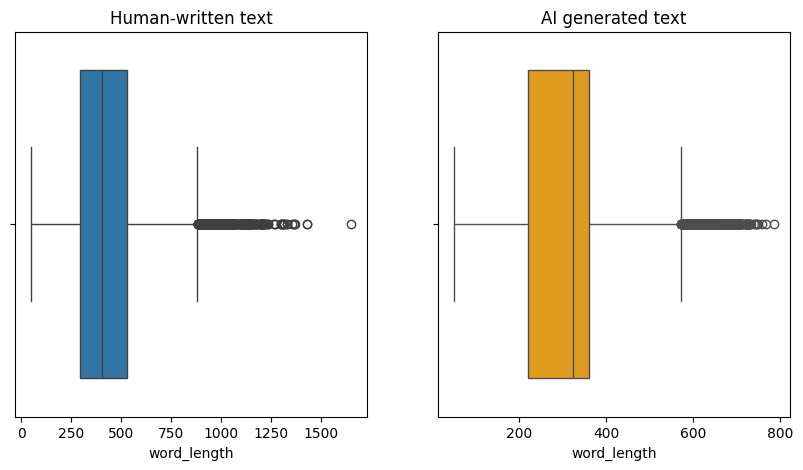

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(data=human_written, x='word_length', ax=ax[0])
ax[0].set_title('Human-written text')
sns.boxplot(data=ai_generated, x='word_length', ax=ax[1], color='orange')
ax[1].set_title('AI generated text')
plt.show()

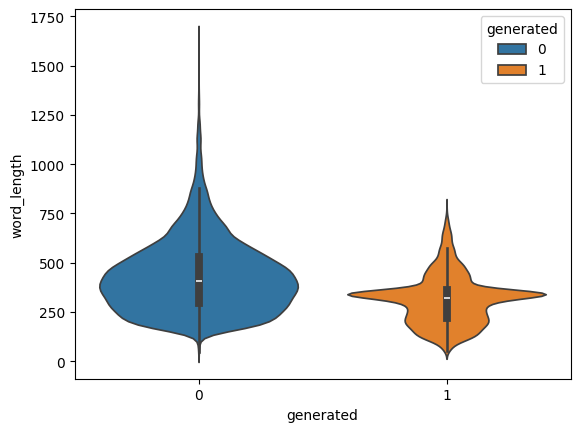

In [25]:
sns.violinplot(data=df, x="generated", y="word_length", hue='generated')
plt.show()

📌 **Findings:**

From the plots above we can see :
- Distribution of human written text are wider and more varied than AI generated text that centralized on 300 words.
- Human written text is has right-skewed distribution and have a tail in right side of plot. In AI generated text, it has a right-skewed too but its kind of symmetrical and centered at 300-370 words.

From this insights we can conclude that human can write whatever length he/she want, but AI have maybe rules to not generating too many words (controlled length), thats why the distribution is centered at a certain point.

In [18]:
df.describe()

,generated,word_length
count,29145.000000,29145.000000
mean,0.399279,382.888008
std,0.489759,171.816705
min,0.000000,1.000000
25%,0.000000,263.000000
50%,0.000000,350.000000
75%,1.000000,474.000000
max,1.000000,1650.000000


In [19]:
# First encounter of noise
noises = df[df['word_length'] <= 10]
noises

,text,generated,word_length
2728,Code] [Email Address] [Phone Number],1,5
2735,] [Email] [Phone Number],1,4
2743,],1,1
2744,] [Email] [Phone Number],1,4
2753,] [Email Address] [Phone Number],1,5
2825,] [Email Address] [Phone Number],1,5


In [20]:
# Remove noise
df.drop(index=noises.index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [21]:
# Desciptive statistic after first cleaning
df.describe()

,generated,word_length
count,29139.000000,29139.000000
mean,0.399156,382.966025
std,0.489733,171.748339
min,0.000000,48.000000
25%,0.000000,263.000000
50%,0.000000,350.000000
75%,1.000000,474.000000
max,1.000000,1650.000000


📌 **Findings:**

I think we can use **min** to determine which data is the noise. we can see that **min** value of **word_length** is now 48 words. I would say that 48 words is make-sense enough for a text.

### Average Sentence Length

In [22]:
df["avg_sentence_length"] = df["text"].apply(utils.avg_sentence_length)
df.head()

,text,generated,word_length,avg_sentence_length
0,Car-free cities have become a subject of incre...,1,575,20.535714
1,"Car Free Cities Car-free cities, a concept gai...",1,513,19.730769
2,A Sustainable Urban Future Car-free cities are...,1,512,18.962963
3,Pioneering Sustainable Urban Living In an era ...,1,519,22.565217
4,The Path to Sustainable Urban Living In an age...,1,511,23.227273


In [26]:
df.describe()

,generated,word_length,avg_sentence_length
count,29139.000000,29139.000000,29139.000000
mean,0.399156,382.966025,22.277629
std,0.489733,171.748339,8.040740
min,0.000000,48.000000,3.364583
25%,0.000000,263.000000,17.625000
50%,0.000000,350.000000,20.600000
75%,1.000000,474.000000,24.815341
max,1.000000,1650.000000,150.500000


In [27]:
human_written = df[df['generated'] == 0]
ai_generated = df[df['generated'] == 1]

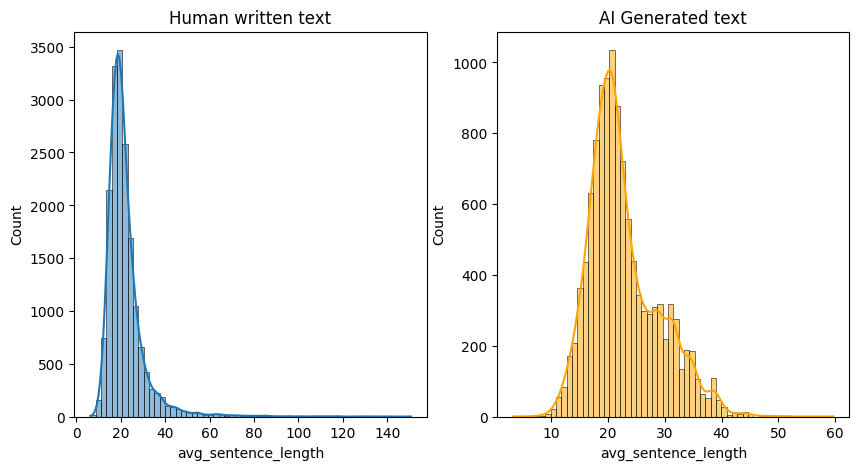

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(data=human_written, x='avg_sentence_length', kde=True, ax=ax[0], bins=60)
ax[0].set_title("Human written text")
sns.histplot(data=ai_generated, x='avg_sentence_length', kde=True, ax=ax[1], color='orange', bins=60)
ax[1].set_title("AI Generated text")
plt.show()

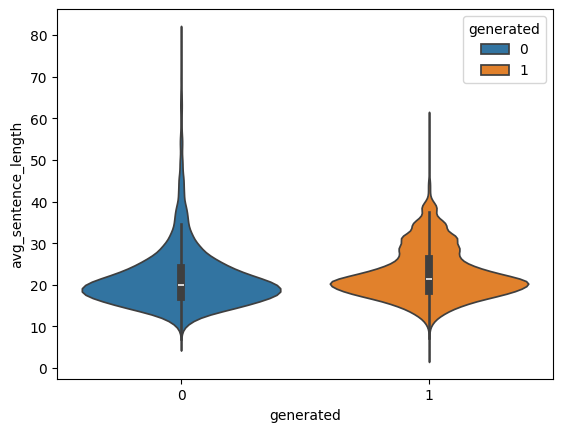

In [29]:
filtered_df = df[df['avg_sentence_length'] <= 80]
sns.violinplot(data=filtered_df, x="generated", y="avg_sentence_length", hue='generated')
plt.show()

📌 **Findings:**

As we can see in these plots,
- The distribution of human-written text is very right-skewed, but in AI generated text is more symmetrical.
- Human-written text is mostly at 10-20 words per sentence, but AI generated text is having 20-25 per sentences.

We can conclude that AI produce stable amount of words per sentence (controlled and consistent), unlike human written text that we as human can write as long or short as we wants.

In [30]:
 df[df["generated"] == 1].describe().T

,count,mean,std,min,25%,50%,75%,max
generated,11631.0,1.000000,0.000000,1.000000,1.000000,1.0,1.000000,1.000000
word_length,11631.0,312.146505,122.948721,50.000000,220.000000,323.0,361.000000,785.000000
avg_sentence_length,11631.0,22.740129,6.141981,3.364583,18.541958,21.3,26.166667,59.666667


In [31]:
 df[df["generated"] == 0].describe().T

,count,mean,std,min,25%,50%,75%,max
generated,17508.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
word_length,17508.0,430.013194,183.049216,48.000000,294.000000,405.000000,529.000000,1650.0
avg_sentence_length,17508.0,21.970380,9.072494,6.413793,17.074074,20.071429,24.105263,150.5


## Punctuation Ratio

In [32]:
df["punct_ratio"] = df["text"].apply(utils.punctuation_ratio)
human_written = df[df["generated"] == 0]
ai_generated = df[df["generated"] == 1]
df.head()

,text,generated,word_length,avg_sentence_length,punct_ratio
0,Car-free cities have become a subject of incre...,1,575,20.535714,0.156522
1,"Car Free Cities Car-free cities, a concept gai...",1,513,19.730769,0.187135
2,A Sustainable Urban Future Car-free cities are...,1,512,18.962963,0.179688
3,Pioneering Sustainable Urban Living In an era ...,1,519,22.565217,0.159923
4,The Path to Sustainable Urban Living In an age...,1,511,23.227273,0.168297


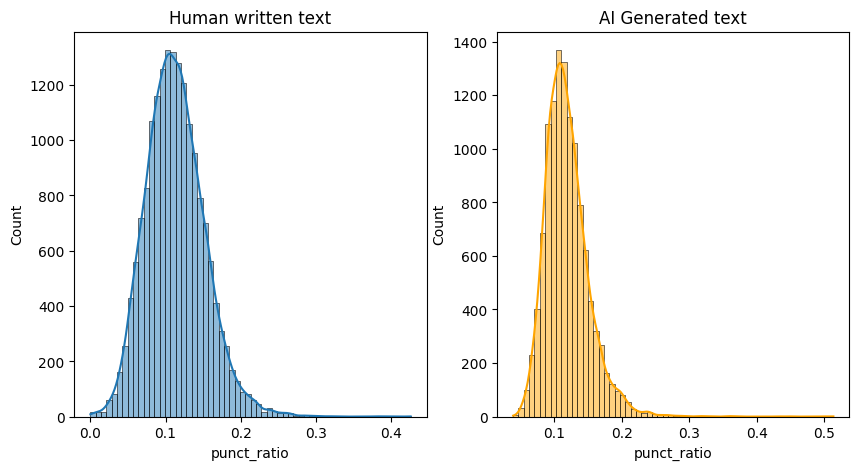

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(data=human_written, x='punct_ratio', kde=True, ax=ax[0], bins=60)
ax[0].set_title("Human written text")
sns.histplot(data=ai_generated, x='punct_ratio', kde=True, ax=ax[1], color='orange', bins=60)
ax[1].set_title("AI Generated text")
plt.show()

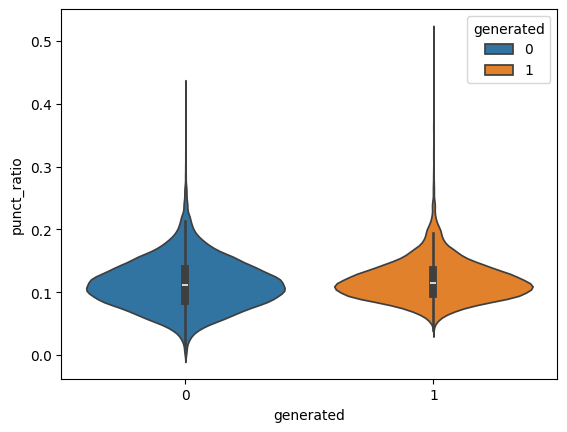

In [34]:
sns.violinplot(data=df, x="generated", y="punct_ratio", hue='generated')
plt.show()

In [35]:
human_written.describe().T

,count,mean,std,min,25%,50%,75%,max
generated,17508.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
word_length,17508.0,430.013194,183.049216,48.000000,294.000000,405.000000,529.000000,1650.000000
avg_sentence_length,17508.0,21.970380,9.072494,6.413793,17.074074,20.071429,24.105263,150.500000
punct_ratio,17508.0,0.113279,0.039099,0.000000,0.086385,0.110787,0.137347,0.426386


In [36]:
ai_generated.describe().T

,count,mean,std,min,25%,50%,75%,max
generated,11631.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
word_length,11631.0,312.146505,122.948721,50.000000,220.000000,323.000000,361.000000,785.000000
avg_sentence_length,11631.0,22.740129,6.141981,3.364583,18.541958,21.300000,26.166667,59.666667
punct_ratio,11631.0,0.119105,0.032564,0.039216,0.096961,0.114865,0.135948,0.513846


## Stopword Ratio

In [37]:
df["stopword_ratio"] = df["text"].apply(utils.stopword_ratio)
human_written = df[df["generated"] == 0]
ai_generated = df[df["generated"] == 1]
df.head()

,text,generated,word_length,avg_sentence_length,punct_ratio,stopword_ratio
0,Car-free cities have become a subject of incre...,1,575,20.535714,0.156522,0.325217
1,"Car Free Cities Car-free cities, a concept gai...",1,513,19.730769,0.187135,0.294347
2,A Sustainable Urban Future Car-free cities are...,1,512,18.962963,0.179688,0.279297
3,Pioneering Sustainable Urban Living In an era ...,1,519,22.565217,0.159923,0.310212
4,The Path to Sustainable Urban Living In an age...,1,511,23.227273,0.168297,0.291585


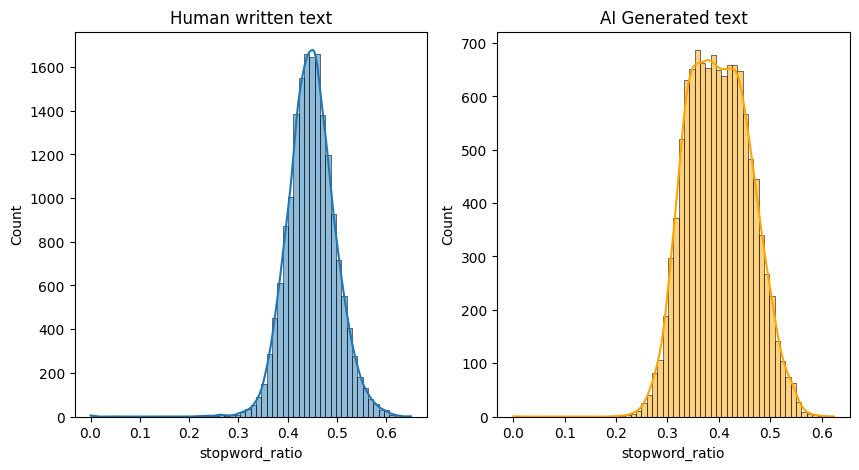

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(data=human_written, x='stopword_ratio', kde=True, ax=ax[0], bins=60)
ax[0].set_title("Human written text")
sns.histplot(data=ai_generated, x='stopword_ratio', kde=True, ax=ax[1], color='orange', bins=60)
ax[1].set_title("AI Generated text")
plt.show()

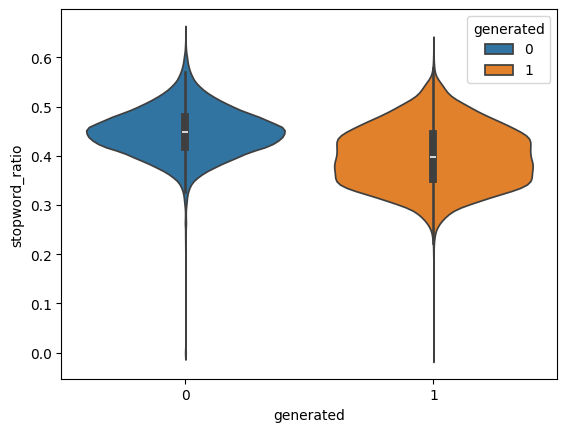

In [39]:
sns.violinplot(data=df, x="generated", y="stopword_ratio", hue='generated')
plt.show()

In [40]:
human_written.describe().T

,count,mean,std,min,25%,50%,75%,max
generated,17508.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
word_length,17508.0,430.013194,183.049216,48.000000,294.000000,405.000000,529.000000,1650.000000
avg_sentence_length,17508.0,21.970380,9.072494,6.413793,17.074074,20.071429,24.105263,150.500000
punct_ratio,17508.0,0.113279,0.039099,0.000000,0.086385,0.110787,0.137347,0.426386
stopword_ratio,17508.0,0.448406,0.048559,0.000000,0.417722,0.447590,0.478554,0.650000


In [41]:
ai_generated.describe().T

,count,mean,std,min,25%,50%,75%,max
generated,11631.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
word_length,11631.0,312.146505,122.948721,50.000000,220.000000,323.000000,361.000000,785.000000
avg_sentence_length,11631.0,22.740129,6.141981,3.364583,18.541958,21.300000,26.166667,59.666667
punct_ratio,11631.0,0.119105,0.032564,0.039216,0.096961,0.114865,0.135948,0.513846
stopword_ratio,11631.0,0.399605,0.061072,0.000000,0.352601,0.397810,0.444444,0.623077


## Word Cloud visualization

In [42]:
ai_text = " ".join(ai_generated["text"])
human_text = " ".join(human_written["text"])

#### AI Generated text wordcloud

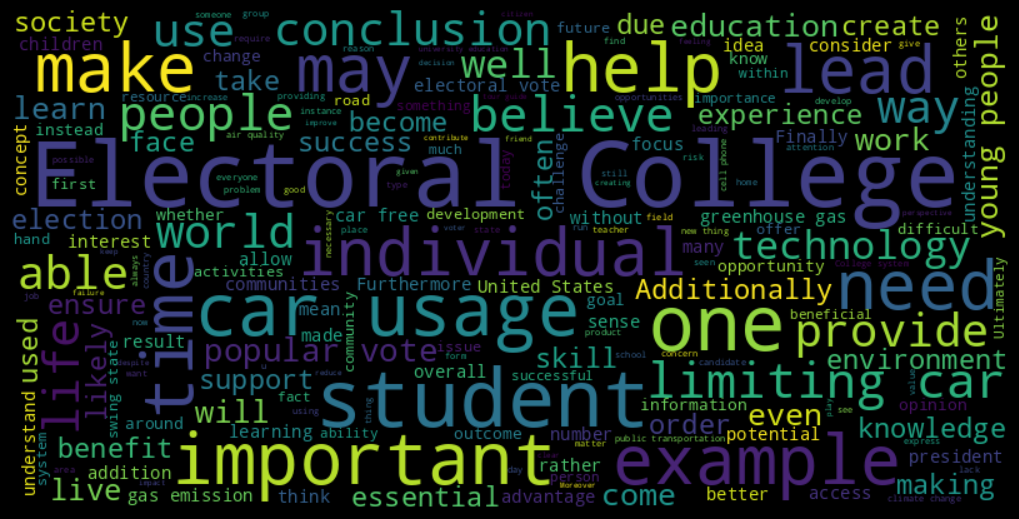

In [43]:
utils.generate_wordcloud(ai_text)

#### Human Written text wordcloud

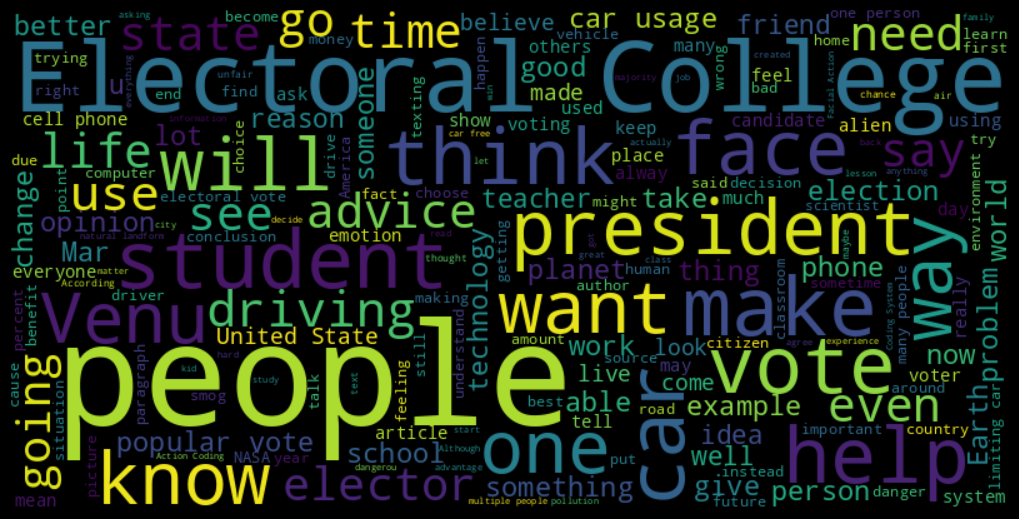

In [44]:
utils.generate_wordcloud(human_text)

## N-gram Analysis

### Unigram

In [45]:
unigram_ai = utils.find_ngram(df=ai_generated.text, ngram=(1,1), max_features=20)
unigram_human = utils.find_ngram(df=human_written.text, ngram=(1,1), max_features=20)

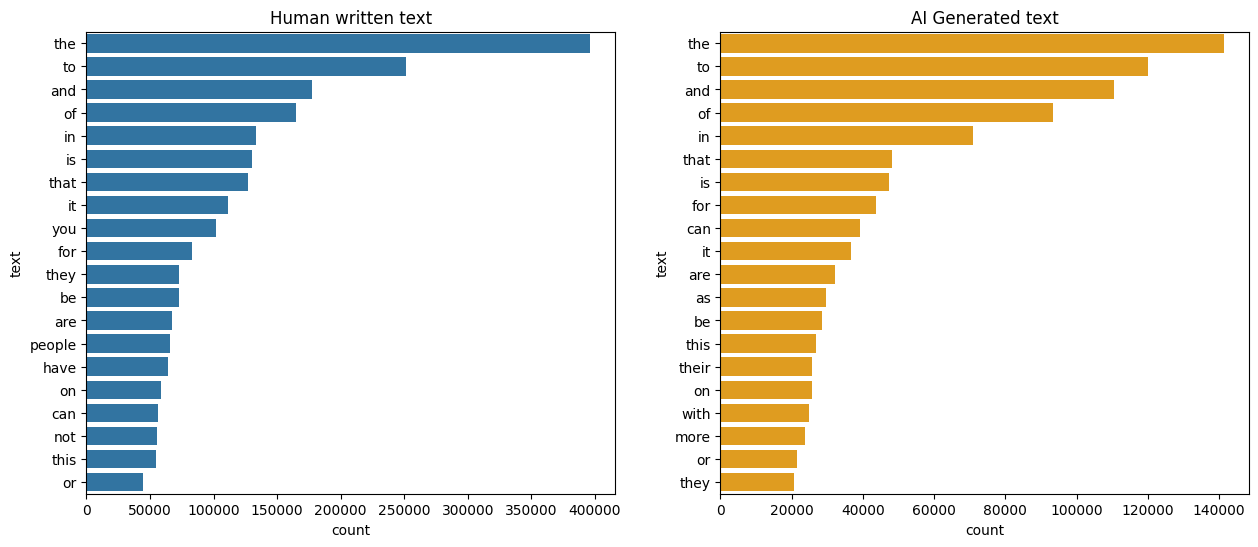

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(data=unigram_human, x="count", y="text", ax=ax[0])
ax[0].set_title("Human written text")
sns.barplot(data=unigram_ai, x="count", y="text", ax=ax[1], color="orange")
ax[1].set_title("AI Generated text")
plt.show()

### Bigram

In [47]:
bigram_ai = utils.find_ngram(df=ai_generated.text, ngram=(2,2), max_features=20)
bigram_human = utils.find_ngram(df=human_written.text, ngram=(2,2), max_features=20)

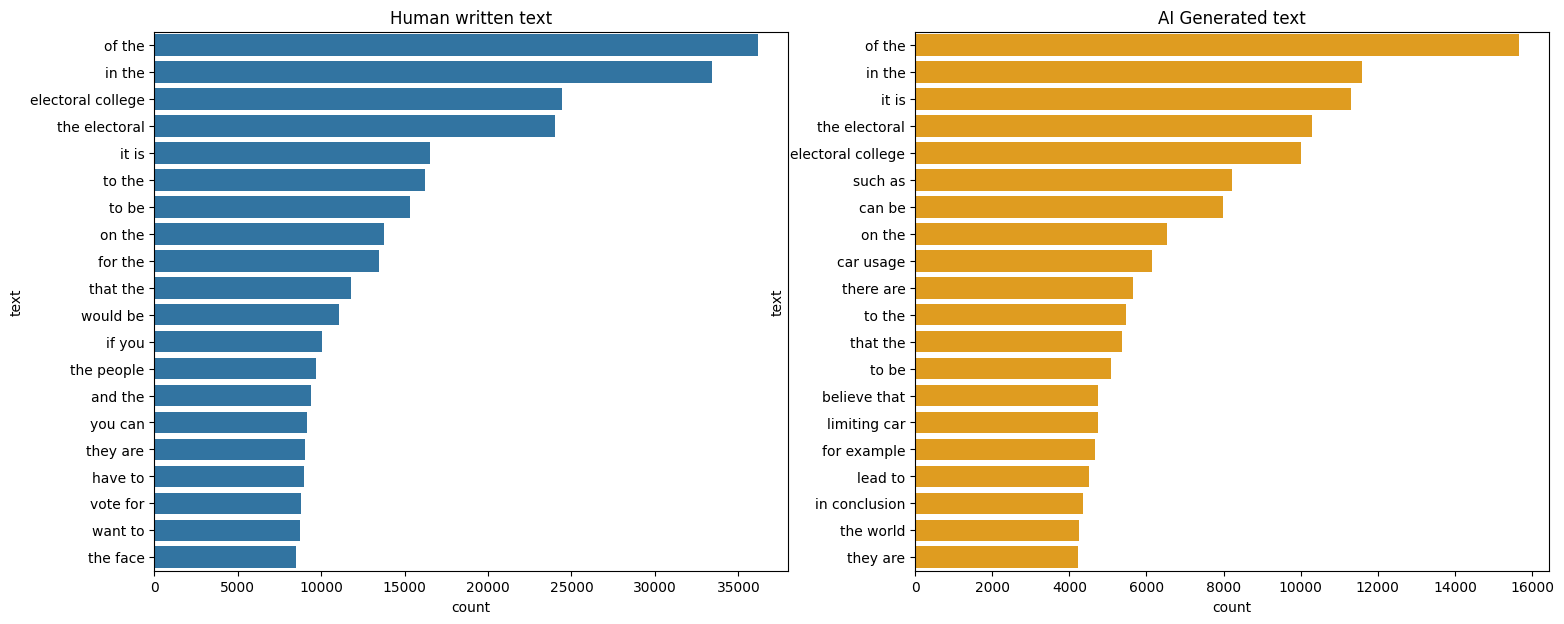

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))
sns.barplot(data=bigram_human, x="count", y="text", ax=ax[0])
ax[0].set_title("Human written text")
sns.barplot(data=bigram_ai, x="count", y="text", ax=ax[1], color="orange")
ax[1].set_title("AI Generated text")
plt.show()

### Trigram

In [49]:
trigram_ai = utils.find_ngram(df=ai_generated.text, ngram=(3,3), max_features=20)
trigram_human = utils.find_ngram(df=human_written.text, ngram=(3,3), max_features=20)

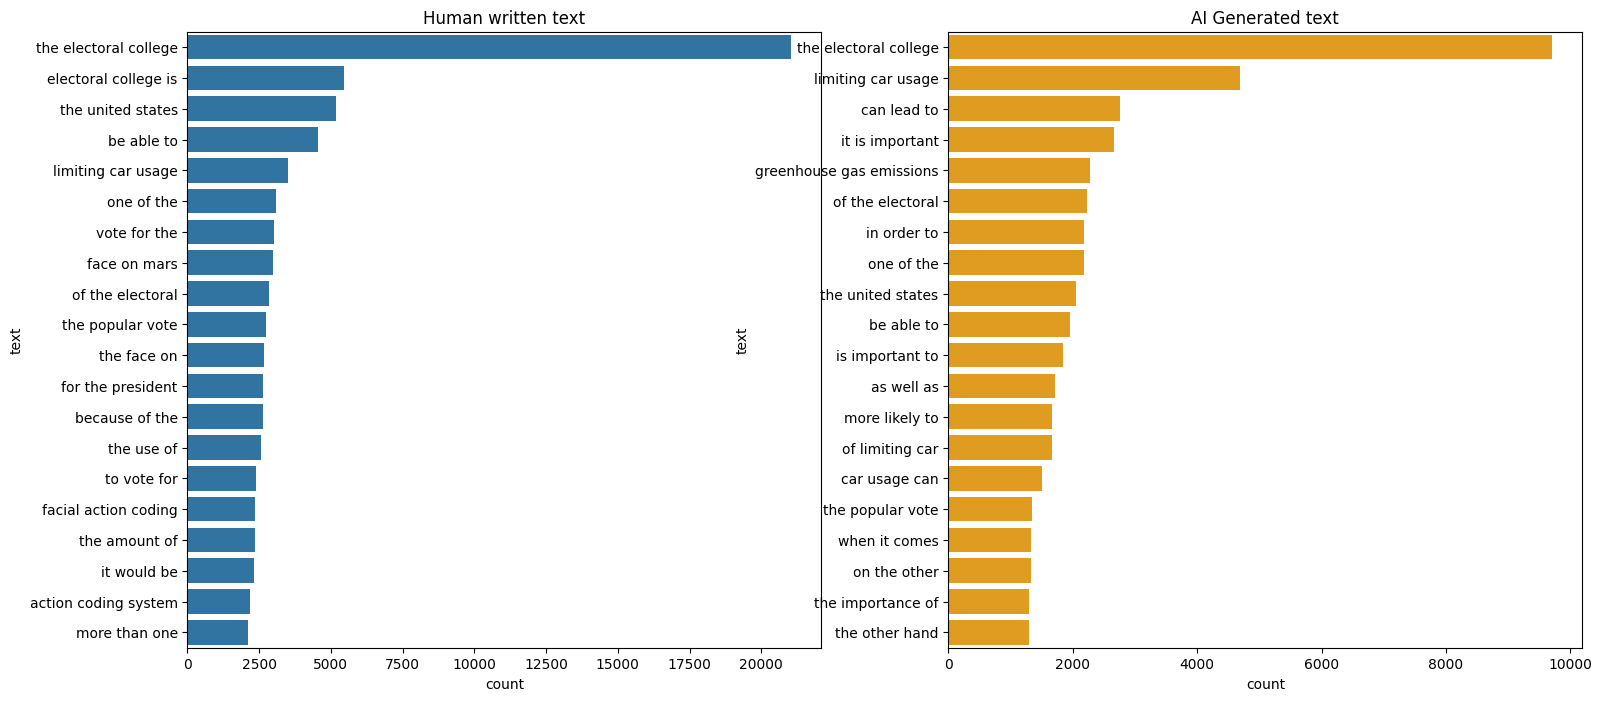

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.barplot(data=trigram_human, x="count", y="text", ax=ax[0])
ax[0].set_title("Human written text")
sns.barplot(data=trigram_ai, x="count", y="text", ax=ax[1], color="orange")
ax[1].set_title("AI Generated text")
plt.show()

## Modeling

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from preprocess_daight import FeatureExtractor

In [52]:
X = df[["text","word_length", "avg_sentence_length", "punct_ratio", "stopword_ratio"]]
y = df["generated"]

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=0.3, random_state=42)

In [54]:
text_transformer = TfidfVectorizer(ngram_range=(1,2), max_features=3000, min_df=2)
numeric_transformer = RobustScaler()
cleaner = Cleaner()
extractor = FeatureExtractor()

preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, "text"),
        ("num", numeric_transformer, ["word_length", "avg_sentence_length", "punct_ratio", "stopword_ratio"])
    ]
)

In [55]:
pipeline = Pipeline([
    ("cleaning", cleaner),
    ("extract", extractor),
    ("preprocessing", preprocessor),
    ("clf", LogisticRegression(max_iter=2000, C=0.1, penalty="l2", solver="saga"))
])

In [56]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('cleaning', Cleaner()),
                ('extract',
                 <preprocess_daight.FeatureExtractor object at 0x7b2cf9e0ecc0>),
                ('preprocessing',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=3000,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'text'),
                                                 ('num', RobustScaler(),
                                                  ['word_length',
                                                   'avg_sentence_length',
                                                   'punct_ratio',
                                                   'stopword_ratio'])])),
                ('clf',
                 LogisticRegression(C=0.1, max_iter=2000, solver='saga'))])

In [59]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5274
           1       0.98      0.95      0.96      3468

    accuracy                           0.97      8742
   macro avg       0.97      0.97      0.97      8742
weighted avg       0.97      0.97      0.97      8742



In [60]:
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Test accuracy:", accuracy_score(y_test, y_test_pred))

Train accuracy: 0.9745550816296514
Test accuracy: 0.9717455959734614


In [61]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1_macro')

print("CV mean:", scores.mean())
print("CV std:", scores.std())

CV mean: 0.9731496996496516
CV std: 0.0021040756070359458


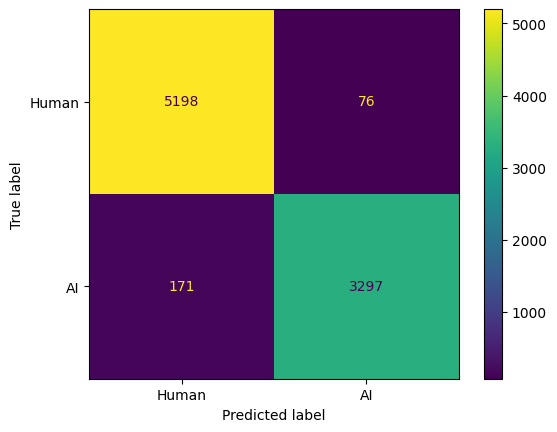

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred), display_labels=["Human", "AI"]).plot()
plt.show()

### Random Forest

In [95]:
random_forest = Pipeline([
    ("cleaning", cleaner),
    ("extract", extractor),
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=100, max_depth=200))
])

In [96]:
random_forest.fit(X_train, y_train)

Pipeline(steps=[('cleaning', Cleaner()),
                ('extract',
                 <preprocess_daight.FeatureExtractor object at 0x7b2cf9e0ecc0>),
                ('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=3000,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'text'),
                                                 ('num', RobustScaler(),
                                                  ['word_length',
                                                   'avg_sentence_length',
                                                   'punct_ratio',
                                                   'stopword_ratio'])])),
                ('clf', RandomForestClassifier(max_depth=200))])

In [97]:
y_pred_rf = random_forest.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5274
           1       0.99      0.98      0.99      3468

    accuracy                           0.99      8742
   macro avg       0.99      0.99      0.99      8742
weighted avg       0.99      0.99      0.99      8742



In [98]:
y_train_pred = random_forest.predict(X_train)
y_test_pred = random_forest.predict(X_test)

print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Test accuracy:", accuracy_score(y_test, y_test_pred))

Train accuracy: 1.0
Test accuracy: 0.9882177991306337


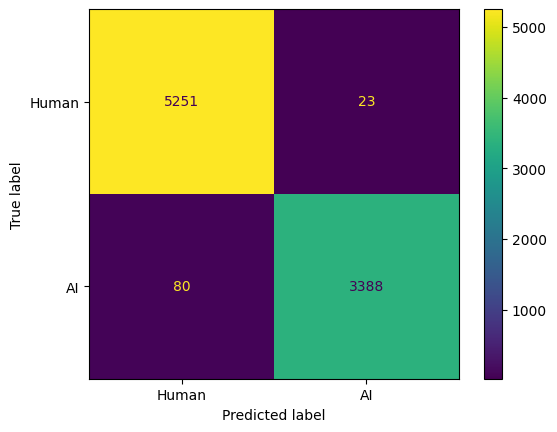

In [99]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred), display_labels=["Human", "AI"]).plot()
plt.show()

In [68]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(random_forest, X, y, cv=cv, scoring='f1_macro')

print("CV mean:", scores.mean())
print("CV std:", scores.std())

CV mean: 0.9876140754530305
CV std: 0.001903090925670562


### Naive Bayes


In [70]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

In [71]:
numeric_transformer_nb = MinMaxScaler()

preprocessor_nb = ColumnTransformer(
    transformers=[
        ("text", text_transformer, "text"),
        ("num", numeric_transformer_nb, ["word_length", "avg_sentence_length", "punct_ratio", "stopword_ratio"])
    ]
)

In [100]:
naive_bayes = Pipeline([
    ("cleaning", cleaner),
    ("extract", extractor),
    ("preprocessor", preprocessor_nb),
    ("clf", MultinomialNB())
])

In [101]:
naive_bayes.fit(X_train, y_train)

Pipeline(steps=[('cleaning', Cleaner()),
                ('extract',
                 <preprocess_daight.FeatureExtractor object at 0x7b2cf9e0ecc0>),
                ('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=3000,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'text'),
                                                 ('num', MinMaxScaler(),
                                                  ['word_length',
                                                   'avg_sentence_length',
                                                   'punct_ratio',
                                                   'stopword_ratio'])])),
                ('clf', MultinomialNB())])

In [102]:
y_pred_nb = naive_bayes.predict(X_test)
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5274
           1       0.99      0.94      0.96      3468

    accuracy                           0.97      8742
   macro avg       0.97      0.96      0.97      8742
weighted avg       0.97      0.97      0.97      8742



In [103]:
y_train_pred = naive_bayes.predict(X_train)
y_test_pred = naive_bayes.predict(X_test)

print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Test accuracy:", accuracy_score(y_test, y_test_pred))

Train accuracy: 0.9650929058194833
Test accuracy: 0.9688858384808968


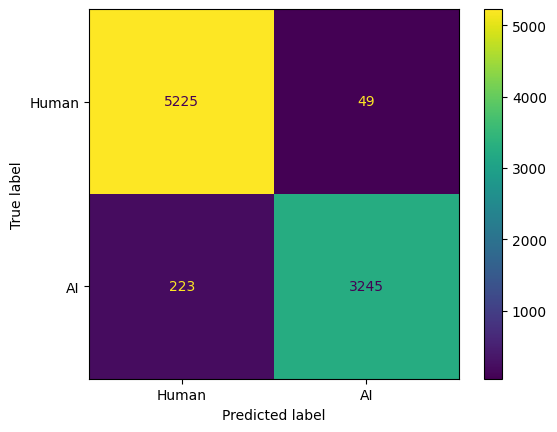

In [104]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred), display_labels=["Human", "AI"]).plot()
plt.show()

In [77]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(naive_bayes, X, y, cv=cv, scoring='f1_macro')

print("CV mean:", scores.mean())
print("CV std:", scores.std())

CV mean: 0.963548609157926
CV std: 0.0027849937183726473


### Support Vector Machine (SVM)

In [78]:
from sklearn.svm import SVC

In [105]:
svc = Pipeline([
    ("cleaning", cleaner),
    ("extract", extractor),
    ("preprocessor", preprocessor),
    ("clf", SVC())
])

In [106]:
svc.fit(X_train, y_train)

Pipeline(steps=[('cleaning', Cleaner()),
                ('extract',
                 <preprocess_daight.FeatureExtractor object at 0x7b2cf9e0ecc0>),
                ('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=3000,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'text'),
                                                 ('num', RobustScaler(),
                                                  ['word_length',
                                                   'avg_sentence_length',
                                                   'punct_ratio',
                                                   'stopword_ratio'])])),
                ('clf', SVC())])

In [107]:
y_pred_svc = svc.predict(X_test)
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5274
           1       0.99      0.99      0.99      3468

    accuracy                           0.99      8742
   macro avg       0.99      0.99      0.99      8742
weighted avg       0.99      0.99      0.99      8742



In [108]:
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Test accuracy:", accuracy_score(y_test, y_test_pred))

Train accuracy: 0.9975976859342061
Test accuracy: 0.9929078014184397


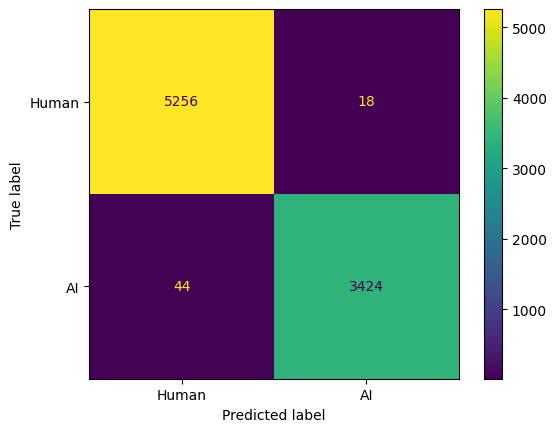

In [109]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred), display_labels=["Human", "AI"]).plot()
plt.show()

In [84]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(svc, X, y, cv=cv, scoring='f1_macro')

print("CV mean:", scores.mean())
print("CV std:", scores.std())

CV mean: 0.9943048664608565
CV std: 0.0012194420673069452


## Hyperparameter Tuning

In [92]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import loguniform

# param_dist = {
#     'clf__C': [0.1, 0.5, 1, 2, 5, 10],
#     'clf__penalty':['l1', 'l2'],
#     'clf__solver':['liblinear', 'saga'],
# }

# # Define RandomizedSearchCV to test combinations of parameters
# random_search = RandomizedSearchCV(
#     estimator=pipeline,
#     param_distributions=param_dist,
#     n_iter=20,
#     cv=5,
#     scoring='accuracy',
#     n_jobs=-1,
#     random_state=42
# )

# # Fitting train data to find best parameters
# random_search.fit(X_train, y_train)

# # Result
# print("Best params:", random_search.best_params_)
# print("Best CV score:", random_search.best_score_)
# print("Test score:", random_search.score(X_test, y_test))

## Model Validation

In [88]:
df_val = pd.read_csv("/content/evaluation_dataset.csv")
X_val = df_val[["text"]]
y_val = df_val["generated"]


In [89]:
def predict_input(data, pipeline, return_df=True):
  if isinstance(data, str):
    df = pd.DataFrame({"text": data})
  elif isinstance(data, list):
    df = pd.DataFrame({"text": data})
  elif isinstance(data, str) and data.endswith(".csv"):
    df = pd.read_csv(data)
  elif isinstance(data, pd.DataFrame):
    df = data.copy()

  else:
    raise ValueError("Input tidak dikenali. Gunakan str, list, DataFrame atau file csv")

  if "text" not in df.columns:
    raise ValueError("Data harus meimiliki kolom 'text'")

  preds = pipeline.predict(df)
  df["prediction"] = preds

  return df if return_df else preds

### Logistic Regression

In [90]:
y_val_pred = predict_input(X_val, pipeline, return_df=False)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1365
           1       0.97      0.89      0.93      1365

    accuracy                           0.93      2730
   macro avg       0.93      0.93      0.93      2730
weighted avg       0.93      0.93      0.93      2730



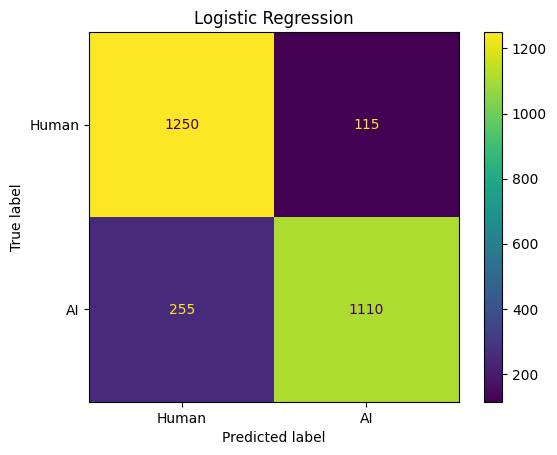

In [132]:
ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred), display_labels=["Human", "AI"]).plot()
plt.title("Logistic Regression")
plt.show()

### Random Forest

In [112]:
y_val_pred = predict_input(X_val, random_forest, return_df=False)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1365
           1       0.98      0.84      0.90      1365

    accuracy                           0.91      2730
   macro avg       0.92      0.91      0.91      2730
weighted avg       0.92      0.91      0.91      2730



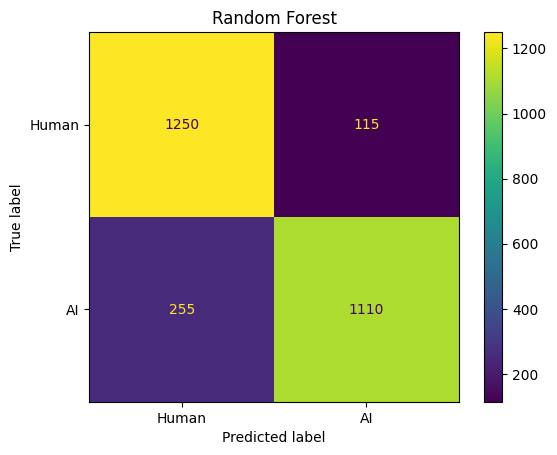

In [133]:
ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred), display_labels=["Human", "AI"]).plot()
plt.title("Random Forest")
plt.show()

### Naive Bayes


In [114]:
y_val_pred = predict_input(X_val, naive_bayes, return_df=False)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1365
           1       0.91      0.81      0.86      1365

    accuracy                           0.86      2730
   macro avg       0.87      0.86      0.86      2730
weighted avg       0.87      0.86      0.86      2730



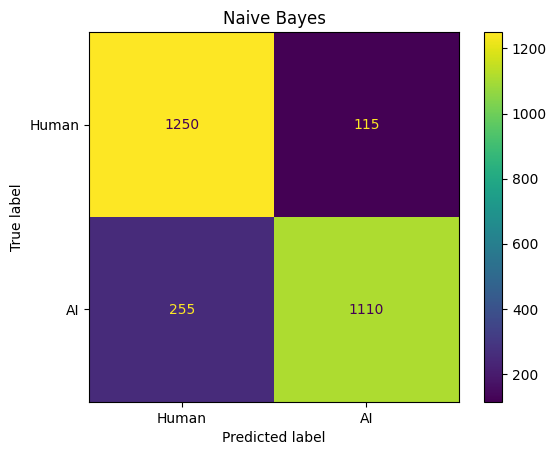

In [134]:
ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred), display_labels=["Human", "AI"]).plot()
plt.title("Naive Bayes")
plt.show()

### SVM

In [136]:
y_val_pred = predict_input(X_val, svc, return_df=False)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1365
           1       0.99      0.94      0.97      1365

    accuracy                           0.97      2730
   macro avg       0.97      0.97      0.97      2730
weighted avg       0.97      0.97      0.97      2730



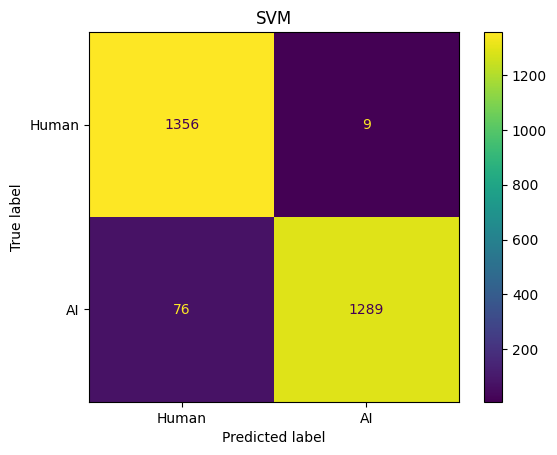

In [137]:
ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred), display_labels=["Human", "AI"]).plot()
plt.title("SVM")
plt.show()